In [1]:
import csv
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle

Using TensorFlow backend.


In [2]:
DS = pd.read_csv("ObjectSubset150SentenceLength.csv")

In [3]:
DS['tag'].fillna('text', inplace=True)

In [4]:
words = list(set(DS["word"].values))
n_words = len(words)
n_words

27741

In [5]:
tags = list(set(DS["tag"].values))
n_tags = len(tags); n_tags


2

In [6]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("text_ID").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [7]:
getter = SentenceGetter(DS)

In [8]:
sentences = getter.sentences


In [9]:
sentences[1]

[('Pt.', 'text'),
 ('tehtud', 'text'),
 ('3', 'text'),
 ('plasmaferees,', 'text'),
 ('talus', 'text'),
 ('hästi.', 'text'),
 ('Eemaldatud', 'text'),
 ('700', 'text'),
 ('ml', 'text'),
 ('plasmat.', 'text'),
 ('RR', 'object'),
 ('112/60', 'object'),
 ('mmHg.', 'text'),
 ('Tgasi', 'text'),
 ('22.10.09.', 'text')]

In [12]:
max_len = 150
max_len_char = 10

In [13]:
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [14]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)


104


In [15]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1 #For predictions
char2idx["PAD"] = 0

In [16]:
idx2char = {i: w for w, i in char2idx.items()}

In [17]:
X_char = []
for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

In [94]:
y = [[tag2idx[w[1]] for w  in s] for s in sentences]


In [21]:
len(sentences)

13643

In [97]:
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')

In [98]:
y[1]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [93]:
tag2idx

{'object': 1, 'text': 2, 'PAD': 0}

In [23]:
from sklearn.model_selection import train_test_split
X_char_tr, X_char_te, y_tr,  y_te= train_test_split(X_char, y, test_size=0.2, random_state=2018)


In [114]:
max_len_char

10

In [24]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D


# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                           input_length=max_len_char, mask_zero=True))(char_in)
# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

# main LSTM
x = SpatialDropout1D(0.3)(char_enc)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.6))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="softmax"))(main_lstm)

model = Model( char_in, out)
 




In [25]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 10)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 150, 10, 10)       1060      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 150, 20)           2480      
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 150, 20)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 100)          28400     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 150, 3)            303       
Total params: 32,243
Trainable params: 32,243
Non-trainable params: 0
_______________________________________________________

In [106]:
a = np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))

In [107]:
a.shape

(10914, 150, 10)

In [112]:
X_char_tr[1].shape

(150, 10)

In [26]:
history = model.fit(np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char)),
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=10, validation_split=0.1, verbose=1)


C:\Users\Kasutaja\Anaconda3\envs\myEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9822 samples, validate on 1092 samples
Epoch 1/10
9822/9822 [==============================] - 72s 7ms/step - loss: 0.0214 - acc: 0.9252 - val_loss: 0.0060 - val_acc: 0.9827
Epoch 2/10
9822/9822 [==============================] - 73s 7ms/step - loss: 0.0055 - acc: 0.9831 - val_loss: 0.0042 - val_acc: 0.9847
Epoch 3/10
9822/9822 [==============================] - 72s 7ms/step - loss: 0.0044 - acc: 0.9848 - val_loss: 0.0033 - val_acc: 0.9876
Epoch 4/10
9822/9822 [==============================] - 71s 7ms/step - loss: 0.0037 - acc: 0.9871 - val_loss: 0.0028 - val_acc: 0.9885
Epoch 5/10
9822/9822 [==============================] - 71s 7ms/step - loss: 0.0034 - acc: 0.9880 - val_loss: 0.0023 - val_acc: 0.9910
Epoch 6/10
9822/9822 [==============================] - 71s 7ms/step - loss: 0.0029 - acc: 0.9902 - val_loss: 0.0019 - val_acc: 0.9924
Epoch 7/10
9822/9822 [==============================] - 70s 7ms/step - loss: 0.0027 - acc: 0.9908 - val_loss: 0.0017 - val_acc: 0.9931
Epoch 8

In [27]:
hist = pd.DataFrame(history.history)


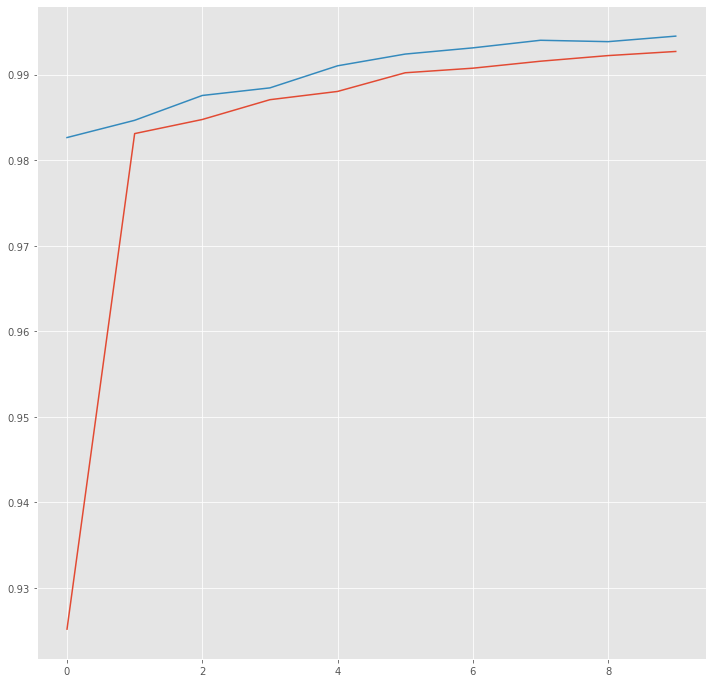

In [28]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()


In [29]:
y_pred = model.predict(
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char)))


In [74]:
def charindx2word(Tword):
    word = []
    for i in range(len(Tword)):
        if(Tword[i] !=0):
            word.append(idx2char[Tword[i]])
    return "".join(word)

In [31]:
i = 1000
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_char_te[i], y_te[i], p):
    if t != 0: #PAD
        print("{:15}: {:5} {}".format(charindx2word(w), idx2tag[t], idx2tag[pred]))


Word           ||True ||Pred
Üldseisnud     : text  text
rahuldav.S     : text  text
regulaarne     : object text
mm             : text  text
Hg.Vesikul     : text  text
hingamiska     : text  text
pehme,valu     : text  text


In [32]:
len(y_pred)

2729

### Wrong Tags


In [87]:
j = 0
for i in range(len(y_pred)):
    p = np.argmax(y_pred[i], axis=-1)
#     print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
#     print(30 * "=")
    for w, t, pred in zip(X_char_te[i], y_te[i], p):
        if charindx2word(w) != "": #PAD
            if idx2tag[t] != idx2tag[pred]:
                print("{:15}: {:5} {}".format(charindx2word(w), idx2tag[t], idx2tag[pred]))
                j = j+1


/106           : text  object
90             : text  object
ebaregulaa     : object text
KORRAS.        : object text
KOORMUSTES     : object text
24-tunni       : object text
Nõustamine     : object text
=              : text  object
kõikumised     : object text
140-90mmhg     : object text
130/82         : object text
100            : text  object
sööki-6,6m     : object text
regulaarne     : object text
178            : object text
kaebusteta     : object text
P185           : text  object
regulaarne     : object text
176/102        : text  object
tarvitanud     : object text
135/92//85     : text  object
min.Pikkus     : object text
189            : object text
min.Pikkus     : object text
189            : object text
Kordusrets     : object text
46cm,          : object text
Analüüsid.     : object text
184/88         : object text
Analüüsid.     : object text
184/88         : object text
regulaarse     : object text
181sm-100k     : text  object
170            : object text
138/82

In [88]:
j

202

In [104]:
i = 1
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_char_te[i], y_te[i], p):
    if t != 0: #PAD
        print("{:15}: {:5} {}".format(charindx2word(w), idx2tag[t], idx2tag[pred]))


Word           ||True ||Pred
01.11.2011     : text  text
-              : text  text
118            : text  text
kg,164         : text  text
cm,BMI         : text  text
43,RR          : object object
150/90         : object object
mmHg,FR        : text  text
~125           : text  text
x´,ebaregu     : text  text
.              : text  text


In [102]:
from seqeval.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "text"))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PAD", "text"))
        out.append(out_i)
    return out

pred_labels = pred2label(y_pred)
test_labels = test2label(y_te)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
print(classification_report(test_labels, pred_labels))


F1-score: 89.5%
           precision    recall  f1-score   support

     text       0.96      0.89      0.92      4461
   object       0.84      0.82      0.83      2104

micro avg       0.92      0.87      0.89      6565
macro avg       0.92      0.87      0.90      6565



In [50]:
accuracy_score(test_labels, pred_labels)

0.9167240747526566

In [58]:
# from sklearn_crfsuite.metrics import flat_classification_report,flat_accuracy_score
# report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
# print(report)
# print("Accuracy",flat_accuracy_score(y_pred=pred_labels, y_true=test_labels))